In [156]:
#Inicjalizacja bibliotek
import os
import numpy as np
import pandas as pd
import glob
import cv2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.layers import Input,Dense, Flatten, MaxPooling2D,Conv2D, BatchNormalization,AveragePooling2D,ZeroPadding2D,LeakyReLU,Add,Activation,Dropout
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.regularizers import l2
%matplotlib inline

rcParams['figure.figsize']=22,10

In [108]:
#Inicjalizacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [109]:
dataset_dict={'race_id':{0:'white',1:'black',2:'asian',3:'indian',4:'others'},'gender_id':{0:'male',1:'female'}}

In [110]:
dataset_dict['gender_alias']=dict((g,i) for i,g in dataset_dict['gender_id'].items())
dataset_dict['race_alias']=dict((g,i) for i,g in dataset_dict['race_id'].items())

In [111]:
dataset_dict

{'race_id': {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 'gender_id': {0: 'male', 1: 'female'},
 'gender_alias': {'male': 0, 'female': 1},
 'race_alias': {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4}}

In [112]:
#Odpowiewdnie przygotowanie zbioru do trenowania sieci
def format_dataset(dataset_path,ext='jpg'):

#Informacje o zdjęciach są zawarte w jego opisie, więc trzeba je wydobyć
    def info_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')
            return int(age),int(gender),int(race)
        except Exception as ex:
            return None, None, None
        
    
    records=[]
    filepaths=[]
    for file in os.listdir(dataset_path):
        info=info_file(file)
        records.append(info)
        filepaths.append(file)
#Zapisanie tych informacji jako DataFrame za pomocą biblioteki pandas
    df = pd.DataFrame(records)
    df['file'] = filepaths
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    return df

In [113]:
df=format_dataset('C:/Users/komej/Downloads/Faces/UTKFace/')

In [114]:
df_test=format_dataset('C:/Users/komej/Downloads/Faces/test/')

In [115]:
df.head()

,age,gender,race,file
0,100.0,0.0,0.0,100_0_0_20170112213500903.jpg.chip.jpg
1,100.0,0.0,0.0,100_0_0_20170112215240346.jpg.chip.jpg
2,100.0,1.0,0.0,100_1_0_20170110183726390.jpg.chip.jpg
3,100.0,1.0,0.0,100_1_0_20170112213001988.jpg.chip.jpg
4,100.0,1.0,0.0,100_1_0_20170112213303693.jpg.chip.jpg


In [116]:
df_test.head()

,age,gender,race,file
0,12,1,0,12_1_0_20170104013219930.jpg.chip.jpg
1,14,1,0,14_1_0_20170109203638205.jpg.chip.jpg
2,15,1,3,15_1_3_20170104221641789.jpg.chip.jpg
3,16,0,0,16_0_0_20170110232218902.jpg.chip.jpg
4,16,1,0,16_1_0_20170109212802540.jpg.chip.jpg


In [203]:
def conv_block(x_in,filters,k,s,bn=True):
    x=Conv2D(filters,kernel_size=(k,k),strides=s,padding='same',kernel_initializer='he_uniform',kernel_regularizer=l2(0.0001))(x_in)
    if bn:
        x=BatchNormalization()(x)
    x=Activation('relu')(x)
    return x
    
def build_model():
    inp=Input(shape=(200,200,3))
    x=conv_block(inp,64,5,1,bn=False)
    x=conv_block(x,64,5,2)
    x=conv_block(x,64,5,1)
    x=conv_block(x,128,4,2)
    x=conv_block(x,128,4,1)
    x=conv_block(x,256,3,2)
    x=conv_block(x,256,3,1)
    x=conv_block(x,512,3,2)
    x=conv_block(x,512,3,1)
    x=conv_block(x,1024,3,2)
    f=Flatten()(x)
    a=Dense(256,activation='relu',kernel_initializer='he_uniform')(f)
    a=Dropout(0.2)(a)
    a=Dense(1,activation='linear',name='age')(a)
    
    r=Dense(256,activation='relu',kernel_initializer='he_uniform')(f)
    r=Dropout(0.2)(r)
    r=Dense(5,activation='softmax',name='race')(r)
    
    g=Dense(256,activation='relu',kernel_initializer='he_uniform')(f)
    g=Dropout(0.2)(g)
    g=Dense(1,activation='sigmoid',name='gender')(g)
    model=Model(inp,[a,r,g])
    return model
    

In [204]:
model=build_model()

In [205]:
#Kompilacja sieci odpowiednimi funkcjami kosztu dla danych funkcji aktywacyjncyh
model.compile(optimizer=Adam(learning_rate=0.0001,decay=0.0001/1000),loss={'age':'mse','race':'categorical_crossentropy','gender':'binary_crossentropy'},loss_weights={'age':4.,'race':1.5,'gender':0.1},metrics={'age':'mae','race':'accuracy','gender':'accuracy'})

In [206]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 200, 200, 64) 4864        input_9[0][0]                    
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 200, 200, 64) 0           conv2d_80[0][0]                  
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 100, 100, 64) 102464      activation_80[0][0]              
____________________________________________________________________________________________

In [207]:
#Funkcja oparta na generatorze, której zadaniem jest wczytanie do pamięci zadaną ilość danych(zdjęć) do trenowania sieci.
def batch_gen(batch_size,df):
    while(1):
        half_path='C:/Users/komej/Downloads/Faces/UTKFace/'
        batches=df.sample(n=batch_size)
        files=batches['file']
        arr=[]
        for i in files:
            arr.append(i)
        age,gender,race=batches['age'], batches['gender'], batches['race']
        age=age/116
        race=to_categorical(race,5)
        org_images=[]
        for img in arr:
            img_train=cv2.imread(half_path+img)
            img_train=cv2.resize(img_train,(200,200))
            org_images.append(img_train)
        org_images=np.array(org_images)
        org_images=org_images.astype('float32')/255
        
        yield(org_images,[np.array(age,dtype='float32'),np.array(race),np.array(gender)])

In [208]:
#Funckja, która zwraca zbiór testowy aby sprawdzić precyzję sieci.
def test_gen(df):
    path='C:/Users/komej/Downloads/Faces/test/'
    files=df['file']
    arr=[]
    for i in files:
        arr.append(i)
    age,gender,race=df['age'],df['gender'],df['race']
    age=age/116
    race=to_categorical(race,5)
    org_images=[]
    for img in arr:
        img_train=cv2.imread(path+img)
        img_train=cv2.resize(img_train,(200,200))
        org_images.append(img_train)
    org_images=np.array(org_images)
    org_images=org_images.astype('float32')/255
    return(org_images,[np.array(age,dtype='float32'),np.array(race),np.array(gender,dtype='float32')])

In [227]:
batch_size=28
epochs=500
train_l,epoch_l,val=[],[],[]
accuracy_train,accuracy_test=[],[]
batches_processed_counter = 0
bat=batch_gen(batch_size,df)
img_test,labels_test=test_gen(df_test)
for e in range(1,epochs+1):
    batches_processed_counter +=1
    imgs,y=next(bat)
    model_loss,loss2,loss3,loss4,mae,accuracy_r,accuracy_g=model.train_on_batch(imgs,y)
    test_loss,loss2,loss3,loss4,test_mae,test_r,test_g=model.test_on_batch(img_test,labels_test)
    #tb.on_epoch_end(batches_processed_counter,{'train_loss':loss1,'train_acc':loss6})
    train_l.append(model_loss)
    epoch_l.append(e)
    val.append(test_loss)
    accuracy_train.append(accuracy_r)
    accuracy_test.append(test_r)
    print('Epoch:',e)
    print('Train loss:','main_loss:',model_loss,'MAE:',mae,'race_acc:',round(accuracy_r,3),'gender_acc:',round(accuracy_g,3))
    print('Test loss:','main_test_loss:',test_loss,'MAE:',test_mae,'race_acc:',round(test_r,3),'gender_acc:',round(test_g,3))
#tb.on_train_end(None)

Epoch: 1
Train loss: main_loss: 1.837889552116394 MAE: 0.09417992830276489 race_acc: 0.714 gender_acc: 0.821
Test loss: main_test_loss: 1.925079584121704 MAE: 0.09695003181695938 race_acc: 0.75 gender_acc: 0.95
Epoch: 2
Train loss: main_loss: 1.415546178817749 MAE: 0.06906279176473618 race_acc: 0.857 gender_acc: 0.893
Test loss: main_test_loss: 1.9045636653900146 MAE: 0.10748617351055145 race_acc: 0.75 gender_acc: 0.95
Epoch: 3
Train loss: main_loss: 1.5406032800674438 MAE: 0.1214241310954094 race_acc: 0.786 gender_acc: 0.929
Test loss: main_test_loss: 1.8778047561645508 MAE: 0.11527100950479507 race_acc: 0.75 gender_acc: 0.9
Epoch: 4
Train loss: main_loss: 1.4004720449447632 MAE: 0.09375327825546265 race_acc: 0.821 gender_acc: 0.964
Test loss: main_test_loss: 1.8479230403900146 MAE: 0.11464873701334 race_acc: 0.75 gender_acc: 0.9
Epoch: 5
Train loss: main_loss: 1.148271918296814 MAE: 0.09996730834245682 race_acc: 0.893 gender_acc: 0.929
Test loss: main_test_loss: 1.8344528675079346 MA

Epoch: 41
Train loss: main_loss: 1.5437616109848022 MAE: 0.09482694417238235 race_acc: 0.75 gender_acc: 1.0
Test loss: main_test_loss: 1.8898118734359741 MAE: 0.10408135503530502 race_acc: 0.8 gender_acc: 0.9
Epoch: 42
Train loss: main_loss: 1.6797478199005127 MAE: 0.08569894731044769 race_acc: 0.786 gender_acc: 0.857
Test loss: main_test_loss: 1.904400110244751 MAE: 0.0994681566953659 race_acc: 0.8 gender_acc: 0.9
Epoch: 43
Train loss: main_loss: 1.6097949743270874 MAE: 0.08599690347909927 race_acc: 0.786 gender_acc: 0.964
Test loss: main_test_loss: 1.9010709524154663 MAE: 0.0980653166770935 race_acc: 0.8 gender_acc: 0.9
Epoch: 44
Train loss: main_loss: 1.1821088790893555 MAE: 0.06951908022165298 race_acc: 0.929 gender_acc: 0.786
Test loss: main_test_loss: 1.9068098068237305 MAE: 0.09284424781799316 race_acc: 0.8 gender_acc: 0.9
Epoch: 45
Train loss: main_loss: 1.5352497100830078 MAE: 0.09330496937036514 race_acc: 0.786 gender_acc: 0.964
Test loss: main_test_loss: 1.9162460565567017 M

Epoch: 81
Train loss: main_loss: 1.4308645725250244 MAE: 0.10316691547632217 race_acc: 0.821 gender_acc: 0.964
Test loss: main_test_loss: 1.8511769771575928 MAE: 0.1014125794172287 race_acc: 0.75 gender_acc: 0.85
Epoch: 82
Train loss: main_loss: 1.6024115085601807 MAE: 0.09049274027347565 race_acc: 0.75 gender_acc: 0.857
Test loss: main_test_loss: 1.8160345554351807 MAE: 0.09475419670343399 race_acc: 0.75 gender_acc: 0.85
Epoch: 83
Train loss: main_loss: 1.7815321683883667 MAE: 0.12332247197628021 race_acc: 0.75 gender_acc: 0.857
Test loss: main_test_loss: 1.848292589187622 MAE: 0.09552010148763657 race_acc: 0.75 gender_acc: 0.85
Epoch: 84
Train loss: main_loss: 1.388164758682251 MAE: 0.12083828449249268 race_acc: 0.893 gender_acc: 0.893
Test loss: main_test_loss: 1.9194984436035156 MAE: 0.09839979559183121 race_acc: 0.75 gender_acc: 0.85
Epoch: 85
Train loss: main_loss: 1.3845399618148804 MAE: 0.09441658109426498 race_acc: 0.964 gender_acc: 0.893
Test loss: main_test_loss: 1.991901636

Epoch: 121
Train loss: main_loss: 1.2438856363296509 MAE: 0.0731048658490181 race_acc: 0.857 gender_acc: 0.929
Test loss: main_test_loss: 2.039379835128784 MAE: 0.11011350154876709 race_acc: 0.7 gender_acc: 0.85
Epoch: 122
Train loss: main_loss: 1.7376893758773804 MAE: 0.07520290464162827 race_acc: 0.714 gender_acc: 0.75
Test loss: main_test_loss: 2.059171199798584 MAE: 0.10501904785633087 race_acc: 0.7 gender_acc: 0.85
Epoch: 123
Train loss: main_loss: 1.3155931234359741 MAE: 0.09893560409545898 race_acc: 0.821 gender_acc: 0.929
Test loss: main_test_loss: 2.101771831512451 MAE: 0.09775320440530777 race_acc: 0.7 gender_acc: 0.85
Epoch: 124
Train loss: main_loss: 1.4316846132278442 MAE: 0.10831987112760544 race_acc: 0.75 gender_acc: 0.893
Test loss: main_test_loss: 2.1205317974090576 MAE: 0.09388500452041626 race_acc: 0.7 gender_acc: 0.85
Epoch: 125
Train loss: main_loss: 1.907004714012146 MAE: 0.07708685845136642 race_acc: 0.643 gender_acc: 0.821
Test loss: main_test_loss: 2.1105394363

Epoch: 161
Train loss: main_loss: 1.040105938911438 MAE: 0.08306027948856354 race_acc: 0.929 gender_acc: 0.929
Test loss: main_test_loss: 2.0942134857177734 MAE: 0.097381591796875 race_acc: 0.75 gender_acc: 0.9
Epoch: 162
Train loss: main_loss: 1.5731557607650757 MAE: 0.10273431986570358 race_acc: 0.75 gender_acc: 0.821
Test loss: main_test_loss: 2.087614059448242 MAE: 0.09521782398223877 race_acc: 0.75 gender_acc: 0.85
Epoch: 163
Train loss: main_loss: 1.4642561674118042 MAE: 0.10305257886648178 race_acc: 0.821 gender_acc: 0.893
Test loss: main_test_loss: 2.102229356765747 MAE: 0.09726990759372711 race_acc: 0.75 gender_acc: 0.85
Epoch: 164
Train loss: main_loss: 1.6090666055679321 MAE: 0.10024093836545944 race_acc: 0.857 gender_acc: 0.857
Test loss: main_test_loss: 2.111262083053589 MAE: 0.10350795835256577 race_acc: 0.7 gender_acc: 0.85
Epoch: 165
Train loss: main_loss: 1.0313321352005005 MAE: 0.11206772178411484 race_acc: 1.0 gender_acc: 0.821
Test loss: main_test_loss: 2.1210999488

Epoch: 201
Train loss: main_loss: 1.3636257648468018 MAE: 0.1154177263379097 race_acc: 0.75 gender_acc: 0.964
Test loss: main_test_loss: 1.9088633060455322 MAE: 0.1045493334531784 race_acc: 0.8 gender_acc: 0.9
Epoch: 202
Train loss: main_loss: 1.125886082649231 MAE: 0.07536526024341583 race_acc: 0.857 gender_acc: 0.929
Test loss: main_test_loss: 1.8995269536972046 MAE: 0.10354216396808624 race_acc: 0.75 gender_acc: 0.85
Epoch: 203
Train loss: main_loss: 1.2874053716659546 MAE: 0.09916245937347412 race_acc: 0.857 gender_acc: 0.893
Test loss: main_test_loss: 1.9099957942962646 MAE: 0.10449439287185669 race_acc: 0.75 gender_acc: 0.85
Epoch: 204
Train loss: main_loss: 1.504960298538208 MAE: 0.0831000804901123 race_acc: 0.786 gender_acc: 0.964
Test loss: main_test_loss: 1.9098981618881226 MAE: 0.10256920009851456 race_acc: 0.75 gender_acc: 0.85
Epoch: 205
Train loss: main_loss: 1.1979767084121704 MAE: 0.09709882736206055 race_acc: 0.821 gender_acc: 0.929
Test loss: main_test_loss: 1.9050006

Epoch: 241
Train loss: main_loss: 1.3935329914093018 MAE: 0.08864151686429977 race_acc: 0.893 gender_acc: 0.821
Test loss: main_test_loss: 1.9840099811553955 MAE: 0.11535926908254623 race_acc: 0.75 gender_acc: 0.9
Epoch: 242
Train loss: main_loss: 1.8408515453338623 MAE: 0.11331389844417572 race_acc: 0.643 gender_acc: 0.964
Test loss: main_test_loss: 2.048405647277832 MAE: 0.1147242933511734 race_acc: 0.75 gender_acc: 0.9
Epoch: 243
Train loss: main_loss: 1.2452564239501953 MAE: 0.0972573384642601 race_acc: 0.857 gender_acc: 1.0
Test loss: main_test_loss: 2.0963032245635986 MAE: 0.11116205155849457 race_acc: 0.75 gender_acc: 0.9
Epoch: 244
Train loss: main_loss: 0.9515346884727478 MAE: 0.08993043005466461 race_acc: 0.964 gender_acc: 0.964
Test loss: main_test_loss: 2.1254000663757324 MAE: 0.10335133969783783 race_acc: 0.75 gender_acc: 0.85
Epoch: 245
Train loss: main_loss: 1.6132824420928955 MAE: 0.08113230764865875 race_acc: 0.821 gender_acc: 0.929
Test loss: main_test_loss: 2.1472692

Epoch: 281
Train loss: main_loss: 1.4699000120162964 MAE: 0.07236601412296295 race_acc: 0.786 gender_acc: 0.857
Test loss: main_test_loss: 2.0300421714782715 MAE: 0.09588295221328735 race_acc: 0.75 gender_acc: 0.9
Epoch: 282
Train loss: main_loss: 1.3035242557525635 MAE: 0.08241287618875504 race_acc: 0.857 gender_acc: 0.929
Test loss: main_test_loss: 2.0374388694763184 MAE: 0.09498908370733261 race_acc: 0.75 gender_acc: 0.9
Epoch: 283
Train loss: main_loss: 1.3322628736495972 MAE: 0.08479977399110794 race_acc: 0.821 gender_acc: 0.893
Test loss: main_test_loss: 2.049999713897705 MAE: 0.09715335816144943 race_acc: 0.75 gender_acc: 0.9
Epoch: 284
Train loss: main_loss: 1.8872804641723633 MAE: 0.0960843414068222 race_acc: 0.714 gender_acc: 0.893
Test loss: main_test_loss: 2.0615901947021484 MAE: 0.0986800566315651 race_acc: 0.8 gender_acc: 0.9
Epoch: 285
Train loss: main_loss: 1.9380347728729248 MAE: 0.07896966487169266 race_acc: 0.607 gender_acc: 0.929
Test loss: main_test_loss: 2.0632681

Epoch: 321
Train loss: main_loss: 1.5372340679168701 MAE: 0.1263781040906906 race_acc: 0.786 gender_acc: 1.0
Test loss: main_test_loss: 1.9072414636611938 MAE: 0.08754940330982208 race_acc: 0.75 gender_acc: 0.95
Epoch: 322
Train loss: main_loss: 1.4490578174591064 MAE: 0.09492353349924088 race_acc: 0.821 gender_acc: 0.821
Test loss: main_test_loss: 1.9364502429962158 MAE: 0.09926490485668182 race_acc: 0.75 gender_acc: 0.95
Epoch: 323
Train loss: main_loss: 1.2042163610458374 MAE: 0.12180808931589127 race_acc: 0.893 gender_acc: 0.714
Test loss: main_test_loss: 1.9587957859039307 MAE: 0.10503892600536346 race_acc: 0.75 gender_acc: 0.95
Epoch: 324
Train loss: main_loss: 1.2030761241912842 MAE: 0.10786541551351547 race_acc: 0.857 gender_acc: 0.929
Test loss: main_test_loss: 1.9370654821395874 MAE: 0.10701825469732285 race_acc: 0.75 gender_acc: 0.9
Epoch: 325
Train loss: main_loss: 1.320369005203247 MAE: 0.09409298002719879 race_acc: 0.857 gender_acc: 0.893
Test loss: main_test_loss: 1.8938

Epoch: 361
Train loss: main_loss: 1.0845117568969727 MAE: 0.08698917925357819 race_acc: 0.893 gender_acc: 0.857
Test loss: main_test_loss: 1.9695234298706055 MAE: 0.08939136564731598 race_acc: 0.8 gender_acc: 0.85
Epoch: 362
Train loss: main_loss: 1.3192499876022339 MAE: 0.07894574105739594 race_acc: 0.75 gender_acc: 0.929
Test loss: main_test_loss: 1.9814817905426025 MAE: 0.08828718215227127 race_acc: 0.8 gender_acc: 0.85
Epoch: 363
Train loss: main_loss: 1.6436330080032349 MAE: 0.08889126777648926 race_acc: 0.75 gender_acc: 0.929
Test loss: main_test_loss: 1.9394439458847046 MAE: 0.0866345763206482 race_acc: 0.8 gender_acc: 0.85
Epoch: 364
Train loss: main_loss: 1.2644850015640259 MAE: 0.08314261585474014 race_acc: 0.893 gender_acc: 0.929
Test loss: main_test_loss: 1.9261280298233032 MAE: 0.08623244613409042 race_acc: 0.75 gender_acc: 0.85
Epoch: 365
Train loss: main_loss: 1.5159170627593994 MAE: 0.1000056117773056 race_acc: 0.75 gender_acc: 0.964
Test loss: main_test_loss: 1.9529187

Epoch: 401
Train loss: main_loss: 1.6258134841918945 MAE: 0.11348854005336761 race_acc: 0.75 gender_acc: 0.893
Test loss: main_test_loss: 2.0535073280334473 MAE: 0.09619621932506561 race_acc: 0.7 gender_acc: 0.95
Epoch: 402
Train loss: main_loss: 1.32292640209198 MAE: 0.07341698557138443 race_acc: 0.857 gender_acc: 1.0
Test loss: main_test_loss: 2.008269786834717 MAE: 0.09649080783128738 race_acc: 0.7 gender_acc: 0.95
Epoch: 403
Train loss: main_loss: 1.616623878479004 MAE: 0.08391417562961578 race_acc: 0.714 gender_acc: 0.929
Test loss: main_test_loss: 1.985740065574646 MAE: 0.09518581628799438 race_acc: 0.7 gender_acc: 0.95
Epoch: 404
Train loss: main_loss: 1.4778040647506714 MAE: 0.08907698094844818 race_acc: 0.786 gender_acc: 0.964
Test loss: main_test_loss: 1.9640467166900635 MAE: 0.09131667762994766 race_acc: 0.75 gender_acc: 0.95
Epoch: 405
Train loss: main_loss: 1.260694146156311 MAE: 0.07196681946516037 race_acc: 0.857 gender_acc: 0.929
Test loss: main_test_loss: 1.97831761837

Epoch: 441
Train loss: main_loss: 1.1621354818344116 MAE: 0.06316707283258438 race_acc: 0.893 gender_acc: 0.929
Test loss: main_test_loss: 1.975494623184204 MAE: 0.09171050786972046 race_acc: 0.8 gender_acc: 1.0
Epoch: 442
Train loss: main_loss: 1.4676557779312134 MAE: 0.06528640538454056 race_acc: 0.821 gender_acc: 0.929
Test loss: main_test_loss: 1.9753624200820923 MAE: 0.08495602756738663 race_acc: 0.75 gender_acc: 0.9
Epoch: 443
Train loss: main_loss: 1.4365814924240112 MAE: 0.10008697956800461 race_acc: 0.929 gender_acc: 0.929
Test loss: main_test_loss: 2.0196075439453125 MAE: 0.07891999185085297 race_acc: 0.75 gender_acc: 0.85
Epoch: 444
Train loss: main_loss: 1.3567222356796265 MAE: 0.0838385820388794 race_acc: 0.821 gender_acc: 0.857
Test loss: main_test_loss: 2.0296847820281982 MAE: 0.07820002734661102 race_acc: 0.75 gender_acc: 0.8
Epoch: 445
Train loss: main_loss: 1.1280829906463623 MAE: 0.10272203385829926 race_acc: 0.893 gender_acc: 0.893
Test loss: main_test_loss: 2.02024

Epoch: 481
Train loss: main_loss: 1.2784265279769897 MAE: 0.06688138842582703 race_acc: 0.893 gender_acc: 0.929
Test loss: main_test_loss: 1.9477717876434326 MAE: 0.09019198268651962 race_acc: 0.85 gender_acc: 0.9
Epoch: 482
Train loss: main_loss: 1.1162611246109009 MAE: 0.08163978159427643 race_acc: 0.857 gender_acc: 0.964
Test loss: main_test_loss: 1.936621069908142 MAE: 0.08680132031440735 race_acc: 0.85 gender_acc: 0.9
Epoch: 483
Train loss: main_loss: 2.2790603637695312 MAE: 0.0839056596159935 race_acc: 0.679 gender_acc: 0.929
Test loss: main_test_loss: 1.9214122295379639 MAE: 0.08351663500070572 race_acc: 0.85 gender_acc: 0.9
Epoch: 484
Train loss: main_loss: 1.1866036653518677 MAE: 0.1009870246052742 race_acc: 0.929 gender_acc: 0.929
Test loss: main_test_loss: 1.9170974493026733 MAE: 0.08158722519874573 race_acc: 0.85 gender_acc: 0.95
Epoch: 485
Train loss: main_loss: 1.2734062671661377 MAE: 0.08232574909925461 race_acc: 0.893 gender_acc: 0.893
Test loss: main_test_loss: 1.90332

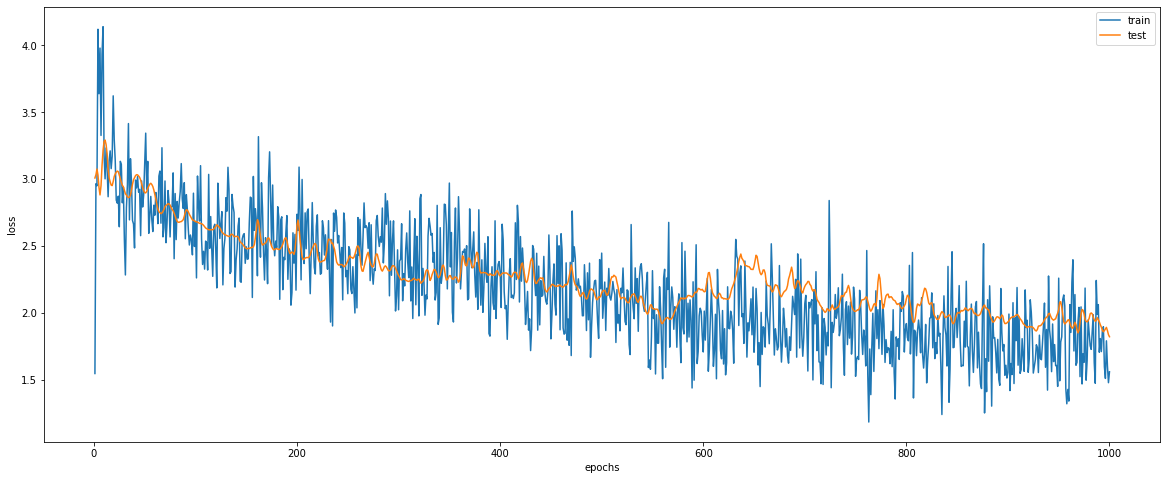

In [211]:
rcParams["figure.figsize"] = (20,8)
plt.plot(epoch_l,train_l,label='train')
plt.plot(epoch_l,val,label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

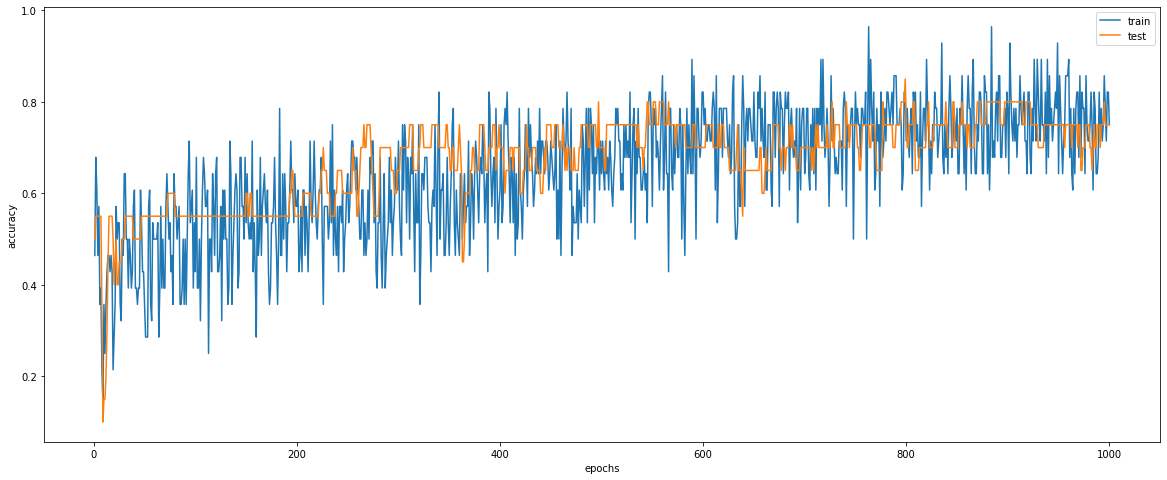

In [212]:
rcParams["figure.figsize"] = (20,8)
plt.plot(epoch_l,accuracy_train,label='train')
plt.plot(epoch_l,accuracy_test,label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

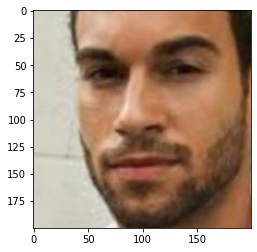

In [220]:
#28_0_0_20170113161024162.jpg.chip.jpg
test_path='C:/Users/komej/Downloads/Faces/UTKFace/28_0_0_20170113161024162.jpg.chip.jpg'

img=cv2.imread(test_path)
img=cv2.resize(img,(200,200),interpolation=cv2.INTER_AREA)
img=img.astype('float32')/255
imgs=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=np.expand_dims(img,axis=0)
rcParams["figure.figsize"] = (20,4)
plt.imshow(imgs)

In [221]:
score=model.predict(img)

In [222]:
score

[array([[0.19099958]], dtype=float32),
 array([[0.55779934, 0.0654164 , 0.01905966, 0.11710421, 0.2406204 ]],
       dtype=float32),
 array([[0.00039674]], dtype=float32)]

In [223]:
age=score[0]
age=age.flatten(order='C')
age=age*116
print(age)

[22.155952]


In [224]:
race=score[1]
race=np.argmax(race)
print(race)

0


In [225]:
gen=score[2]
gen=gen.flatten(order='C')
print(gen)

[0.00039674]


In [98]:
model.save('C:/Users/komej/Downloads/Faces/fac6.h5')